<a href="https://colab.research.google.com/github/cweidig/measuring_bias/blob/main/measure_bias_preprocess_4compare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# read the file mortgage_data_project.pkl from Google drive with pandas' read_pickle()
import pandas as pd
import seaborn as sns
import numpy as np

# Load the datset into a pandas dataframe
from joblib import load

!pip install aif360
!pip install fairlearn

df = load("/content/drive/My Drive/mortgage_data_preprocessed.pkl.gz")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.1/234.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 33.6 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.26.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.1 which is incompatible.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.2.1 which is incompatible.


In [9]:
# Consider the target variable (y) the action_taken_name. The input variables set (X) should contain all the remaining variables

# instantiating X
X = df.drop(labels=df.columns[-1], axis=1)

# instantiating the target variable
y = df[df.columns[-1]]

In [8]:
# set up the fairness metrics
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric

# Set up reweighing
from aif360.algorithms.preprocessing import Reweighing

privileged_group = [{'applicant_sex_name_Female': 0}]
unprivileged_group = [{'applicant_sex_name_Female': 1}]


In [10]:
# Train a logistic regression classifier and calculate fairness metrics and performance metrics

from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", random_state=42)


from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

"""
Split the data using the cross-validator instantiated in the configuration step above.
For each split,
Fit a model using the logistic regression classifier on the training set.
Compute the predicted class labels and probability estimates for the test set.
Compute performance metrics using sklearn: accuracy_score, precision_score, recall_score, roc_auc_score, f1_score.
Compute fairness metrics using AIF360 (see below).
Compute the mean and standard deviation over the 10 folds for each performance and fairness metric and print them in a table
"""

# setup the performance metrics to be computed
from sklearn import metrics
perf_metrics = {"Accuracy": metrics.accuracy_score,
                "Precision": metrics.precision_score,
                "Recall": metrics.recall_score,
                "AUC": metrics.roc_auc_score,
                "F1-Score": metrics.f1_score,
                }

# Split the input and output variables using the cross-validator skf
import pandas as pd
import numpy as np
k, i = True, 1

for (train, test) in skf.split(X, y):

    # reweight train and pred
    dataset = X.iloc[train].copy()
    dataset[df.columns[-1]] = y.iloc[train]
    dataset_aif = BinaryLabelDataset(df=dataset, label_names=['action_taken_name'], protected_attribute_names=['applicant_sex_name_Female'])
    rw = Reweighing(unprivileged_group, privileged_group)
    dataset_transformed = rw.fit_transform(dataset_aif)

    # instantiating X
    X_train = pd.DataFrame(data = dataset_transformed.features, columns=df.columns[:-1])

    # instantiating y
    y_train = pd.DataFrame(data = dataset_transformed.labels.ravel())

    # instantiating the reweighing weights
    w_train = pd.DataFrame(data = dataset_transformed.instance_weights)

    # fit model
    lr = log_reg.fit(X_train, y_train, sample_weight = w_train.to_numpy().ravel())

    # get predictions in the test set
    ypred_prob = lr.predict_proba(X.iloc[test]).ravel()[1::2] # get probabilities
    ypred_class = lr.predict(X.iloc[test])

    # compute performance metrics
    metrics = []
    dataset = X.iloc[test].copy()
    dataset[df.columns[-1]] = np.expand_dims(y.iloc[test], axis=1)
    dataset = BinaryLabelDataset(df=dataset, label_names=['action_taken_name'], protected_attribute_names=['applicant_sex_name_Female'])
    dataset_pred = X.iloc[test].copy()
    dataset_pred[df.columns[-1]] = np.expand_dims(ypred_class, axis=1)
    dataset_pred = BinaryLabelDataset(df=dataset_pred, label_names=['action_taken_name'], protected_attribute_names=['applicant_sex_name_Female'])
    metric_CM = ClassificationMetric(dataset, dataset_pred, privileged_groups=privileged_group, unprivileged_groups=unprivileged_group)
    for pf in perf_metrics.keys():
        if pf in ["AUC", "Brier"]:
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_prob)]]
        else:
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_class)]]

    # Compute fairness metrics
    metrics += [['Statistical Parity Difference', metric_CM.statistical_parity_difference()]]
    metrics += [['Disparate Impact', metric_CM.disparate_impact()]]
    metrics += [['Equal Opportunity Difference', metric_CM.equal_opportunity_difference()]]
    metrics += [['Average Odds Difference', metric_CM.average_odds_difference()]]
    metrics += [['Accuracy Male', metric_CM.accuracy(privileged=True)]]
    metrics += [['Accuracy Female', metric_CM.accuracy(privileged=False)]]

    # concatenate results
    df_m = pd.DataFrame(metrics, columns=["Metric", "Value"])
    df_m["Fold"] = i
    i += 1
    if k:
        df_metrics = df_m.copy()
        k=0
    else:
        df_metrics = pd.concat([df_metrics, df_m.copy()], axis=0, ignore_index=True)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel

In [11]:
# Display metrics
metrics_table = df_metrics.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])
metrics_table

AttributeError: 'MultiIndex' object has no attribute '_format_multi'

                                   mean       std
                                  Value     Value
Metric                                           
AUC                            0.789716  0.002749
Accuracy                       0.692926  0.003640
Accuracy Female                0.662644  0.004780
Accuracy Male                  0.706245  0.005207
Average Odds Difference        0.136185  0.009045
Disparate Impact               1.509668  0.028531
Equal Opportunity Difference   0.115011  0.011563
F1-Score                       0.632947  0.006058
Precision                      0.647829  0.004173
Recall                         0.618802  0.010079
Statistical Parity Difference  0.180239  0.010166

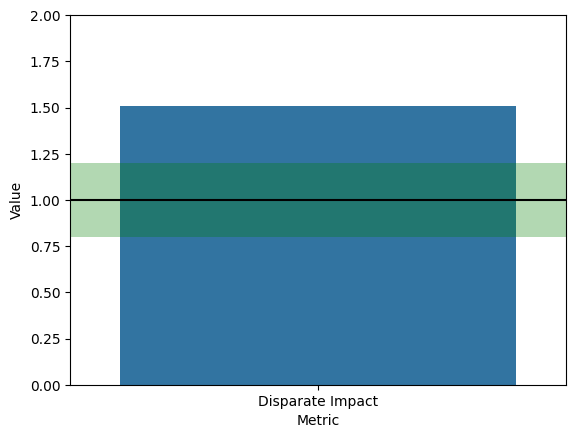

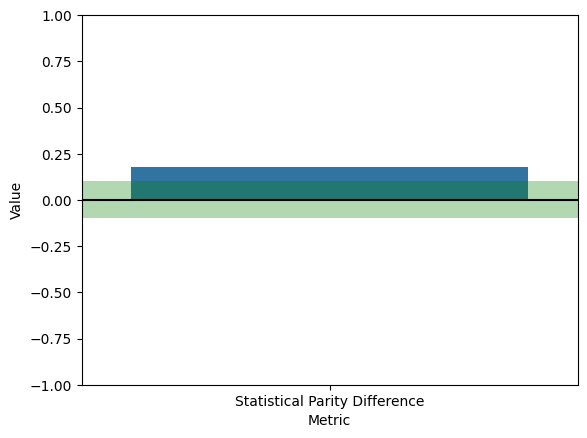

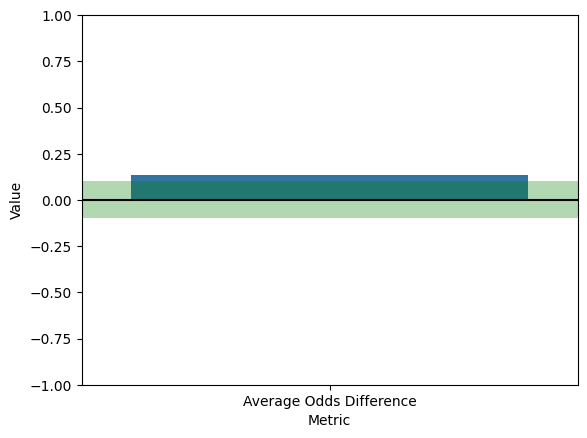

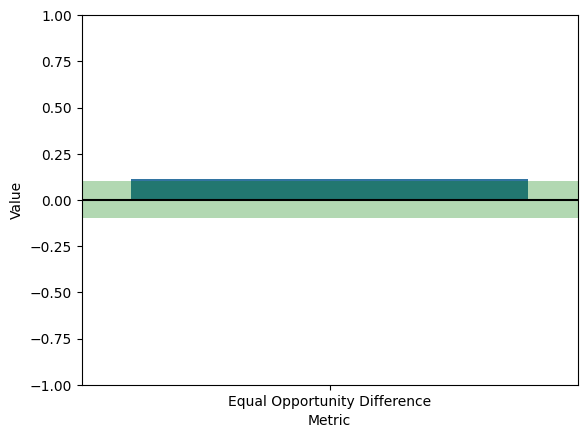

In [12]:
# Use matplotlib to visually show on a graph the 10-fold CV average for each fairness metric with its allowable range
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
import numpy as np

fairness_metrics = metrics_table.filter(regex='Disparate|Difference',axis=0)
fairness_df = pd.DataFrame(columns=["Metric", "Value", "Min", "Max"])
fairness_df.loc[0] = ['Disparate Impact'] + list((fairness_metrics[('mean', 'Value')]['Disparate Impact'], 0.8, 1.2))
fairness_df.loc[1] = ['Statistical Parity Difference'] + list((fairness_metrics[('mean', 'Value')]['Statistical Parity Difference'], -0.1, 0.1))
fairness_df.loc[2] = ['Average Odds Difference'] + list((fairness_metrics[('mean', 'Value')]['Average Odds Difference'], -0.1, 0.1))
fairness_df.loc[3] = ['Equal Opportunity Difference'] + list((fairness_metrics[('mean', 'Value')]['Equal Opportunity Difference'], -0.1, 0.1))

def plot_metrics(df_fair):
  def plot_metric(metric, ylim):
    fig, ax = plt.subplots()
    ax = sns.barplot(data=metric, x="Metric", y="Value")
    plt.axhline(np.mean(metric[["Min", "Max"]].values), color='black')
    plt.ylim(*ylim)
    range_height = metric[["Max"]].values[0][0] - metric[["Min"]].values[0][0]
    ax.add_patch(patches.Rectangle((-1, metric[["Min"]].values[0][0]), 2 , range_height, facecolor="green", alpha=0.3))

  plot_metric(df_fair.iloc[[0]], (0, 2))
  plot_metric(df_fair.iloc[[1]], (-1, 1))
  plot_metric(df_fair.iloc[[2]], (-1, 1))
  plot_metric(df_fair.iloc[[3]], (-1, 1))

plot_metrics(fairness_df)